The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


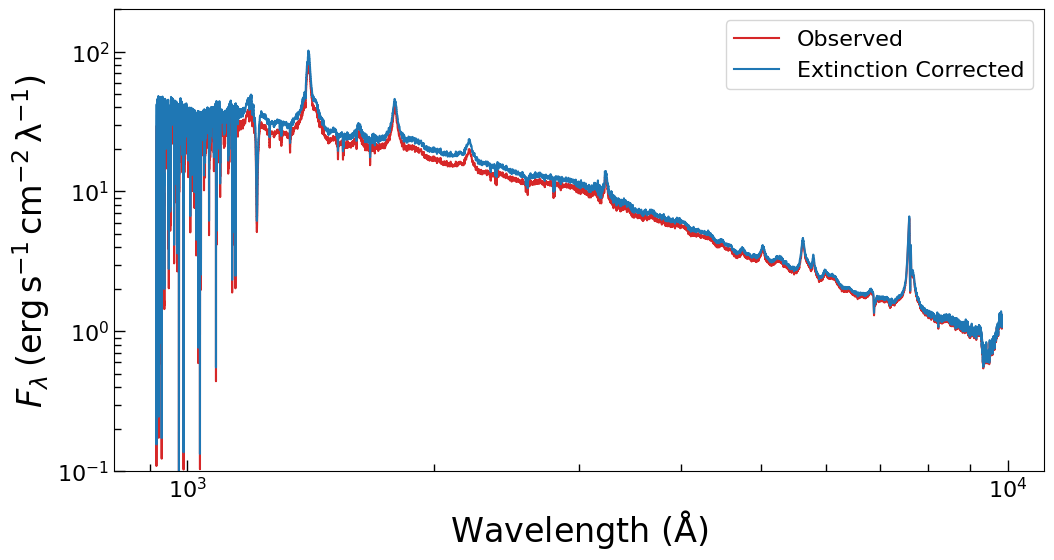

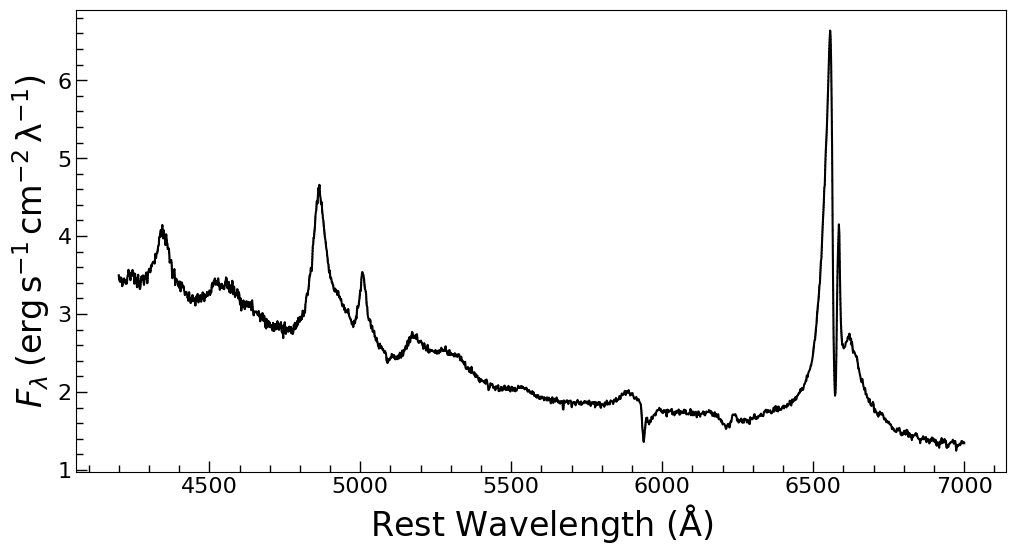

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('3c273sed (2).fit')  #---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.057    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.1, 200)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.1576 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

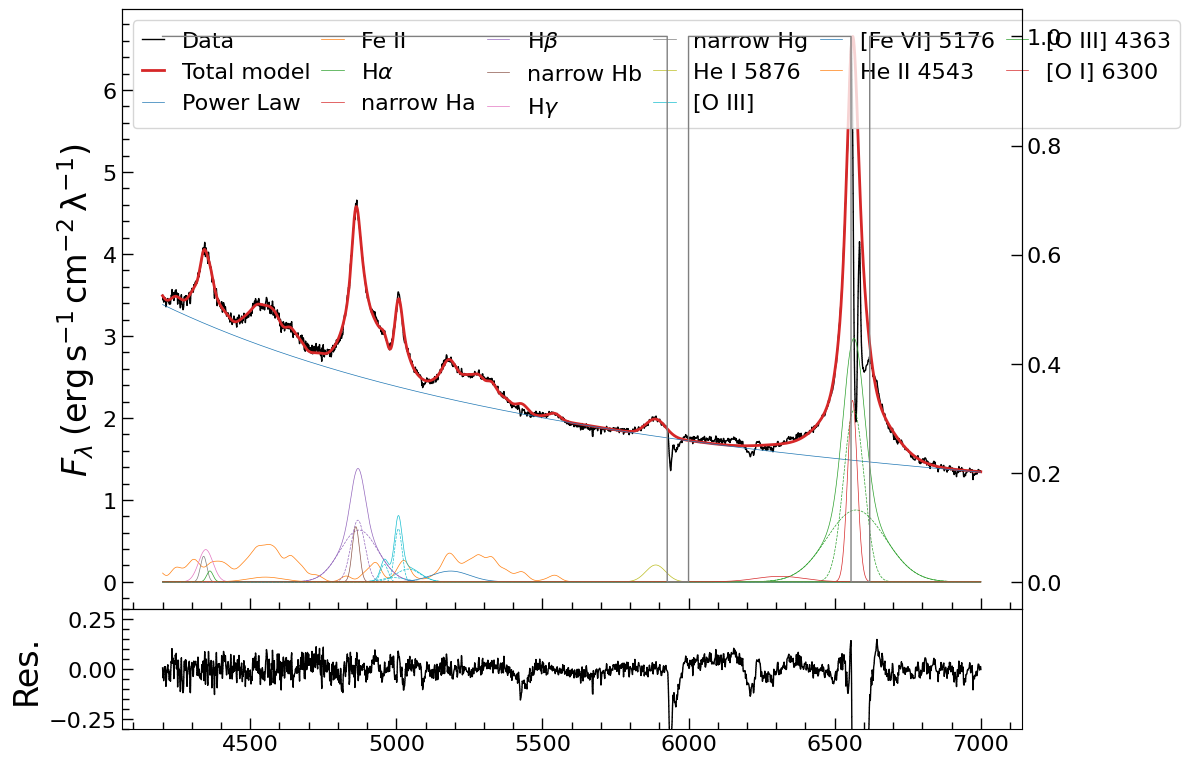

<PowerLaw1D(amplitude=2.4099, x_0=5500., alpha=3.38129, name='Power Law')>
<IronTemplate(amplitude=0.99301, stddev=1240.77, z=0.00113934, name='Fe II')>
<Line_MultiGauss(amp_c=1.87319516, dv_c=111.91891803, sigma_c=1607.60661004, wavec=6562.819, amp_w0=0.41758933, dv_w0=239.18646544, sigma_w0=4576.32926585, name='H$\\alpha$')>
<Line_Gaussian(amplitude=1.98067049, dv=-89.02856298, sigma=756.1042123, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.91577429, dv_c=500., sigma_c=4000., wavec=4862.721, amp_w0=1.19217175, dv_w0=-156.8315866, sigma_w0=1463.30364026, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.97891569, dv=-89.02856298, sigma=756.1042123, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.6680504, dv_c=397.32937362, sigma_c=1688.6917776, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.53079161, dv=-89.02856298, sigma=756.1042123, wavec=4341.785, name='narrow Hg')>
<Line_MultiGauss(amp_c=0.22214621, dv_c=595.55340612, sigma_c=1741.35629449, 

In [32]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=2.4099, x_0=5500., alpha=3.38129, fixed={'x_0': True,'amplitude':True,'alpha':True},name='Power Law') 
iron = sagan.IronTemplate(amplitude=0.99301, stddev=1240.77, z=0., name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=2.2, dv_c=73, sigma_c=1350, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.41, dv_w0=200, sigma_w0=3900)

# It took me quite some time to adjust the 
bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500),'sigma_w0': (100, 4000)}
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.94, dv_c=390, sigma_c=1460, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.94, dv_c=500, sigma_c=4000, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=1.5, dv_w0=-400, sigma_w0=1220, bounds=bounds)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.027, dv_c=500, sigma_c=1700, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.2, dv_c=575, sigma_c=1500, wavec=5875.624, name='He I 5876')


line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.7, amp_c1=0.25, dv_c=-51, sigma_c=680, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.33, dv_w0=2000, sigma_w0=3300,bounds=bounds)
#line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.01, amp_c1=0.01,
#                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

n_ha = sagan.Line_Gaussian(amplitude=1.36, wavec=wave_dict['Halpha'], name=f'narrow Ha') 
n_hg = sagan.Line_Gaussian(amplitude=0.19, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_hb = sagan.Line_Gaussian(amplitude=0.48, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_he2 = sagan.Line_Gaussian(amplitude=0.11, wavec=wave_dict['HeII_4686'], name=f'narrow He2')


b_fe6_5176 = sagan.Line_MultiGauss(n_components=1, amp_c=0.073, dv_c=0, sigma_c=1000, wavec=wave_dict['FeVI_5176'], name='[Fe VI] 5176',bounds=bounds) 
#b_fe3_5047= sagan.Line_MultiGauss(n_components=1, amp_c=0.1, dv_c=0, sigma_c=500, wavec=wave_dict['FeIII_5047'], name='[Fe III] 5047')
b_he2_4543= sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=0, sigma_c=500, wavec=4543, name='He II 4543',bounds=bounds)
b_o1_6300= sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=0, sigma_c=500, wavec=wave_dict['OI_6300'], name='[O I] 6300',bounds=bounds)

line_ha  =  b_ha + n_ha
line_hg  =  b_hg + n_hg
line_hb  =  b_hb + n_hb
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1

m_init = (pl + iron+ line_ha+line_hb  + line_hg +line_he1+ line_o3+b_fe6_5176 +b_he2_4543+n_o3_4363 +b_o1_6300)*poly

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

#def tie_n2(model):
#    return model['[N II]'].amp_c0 / 2.96
#line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

#line_s2.sigma_c.tied = tie_narrow_sigma
#line_s2.dv_c.tied = tie_narrow_dv
#line_n2.sigma_c.tied = tie_narrow_sigma
#line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2,n_o3_4363]: 
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 5927) & (wave_use < 6000)
#fltr2 = (wave_use > 4880) & (wave_use < 5112)
fltr3 = (wave_use > 6556) & (wave_use < 6620)
#fltr4 = (wave_use > 4250) & (wave_use < 4450)
fltr11= (wave_use > 4260) & (wave_use < 4430)
fltr12= (wave_use > 4770) & (wave_use < 5080)
fltr13= (wave_use > 5550) & (wave_use < 6050)
fltr14= (wave_use > 6200) & (wave_use < 6890)


weights[fltr1] = 0.0
#weights[fltr2] = 0.0
weights[fltr3] = 0.0
#weights[fltr4] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
axr.set_ylim(-0.3,0.3)
plt.show()

for m in m_fit:
    print(m.__repr__())